# Short-Horizon Stock Selection via Machine Learning: A Volatility-Adjusted Portfolio Approach



In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf


def compute_features_and_label(data, ticker):
    df = pd.DataFrame()

    p_open = data['Open'][ticker]
    p_high = data['High'][ticker]
    p_low = data['Low'][ticker]
    p_close = data['Close'][ticker]
    p_volume = data['Volume'][ticker]

    df['price_open'] = p_open
    df['price_high'] = p_high
    df['price_low'] = p_low
    df['price_close'] = p_close
    df['volume'] = p_volume

    # Daily return
    daily_returns_open = p_open.pct_change()
    daily_returns_close = p_close.pct_change()

    # Label: next day's open return
    df['label'] = daily_returns_open.shift(-1)

    # --- Features ---
    df['rev_1'] = daily_returns_close.shift(1) * -1
    df['mom_5'] = p_open.pct_change(5)
    df['mom_20'] = p_open.pct_change(20)
    df['rv_20'] = daily_returns_close.rolling(20).std()
    df['arv_5'] = df['rv_20'] - df['rv_20'].shift(5)

    # ATR
    p_close_prev = p_close.shift(1)
    tr = pd.DataFrame({
        'H-L': p_high - p_low,
        'H-PC': abs(p_high - p_close_prev),
        'L-PC': abs(p_low - p_close_prev)
    }).max(axis=1)
    df['atr_14'] = tr.ewm(span=14, adjust=False).mean()

    # Market proxy
    df['spy_ret_1'] = data['Open']['SPY'].pct_change(1)

    # Candlestick structure
    df['ret_oc'] = (p_close - p_open) / p_open
    df['ret_hl'] = (p_high - p_low) / p_open
    df['upper_shadow'] = (p_high - np.maximum(p_open, p_close)) / p_open
    df['lower_shadow'] = (np.minimum(p_open, p_close) - p_low) / p_open

    # Volume / liquidity
    df['value_traded'] = p_close * p_volume
    df['volume_ratio_20'] = p_volume / p_volume.rolling(20).mean()

    # Overnight return
    df['overnight_ret'] = p_open / p_close.shift(1) - 1

    df = df.dropna()

    X = df.drop(columns=["label"])
    Y = df["label"]

    return X, Y


# === Each stock: Winsorization + Z-score ===
def apply_ts_scaling_and_winsorization(df_X, rolling_window=252, lower_percentile=0.01, upper_percentile=0.99):
    X_processed = df_X.copy()

    # rolling quantiles and stats based only on *past data*
    rolling_stats = (
        df_X.rolling(window=rolling_window, min_periods=20)
        .agg({
            col: ['mean', 'std',
                  lambda x: x.quantile(lower_percentile),
                  lambda x: x.quantile(upper_percentile)]
            for col in df_X.columns
        })
    )
    rolling_stats.columns = [f"{col[0]}_{col[1]}" for col in rolling_stats.columns]
    rolling_stats = rolling_stats.shift(1)  # shift to use only past info

    for feature in df_X.columns:
        mu = rolling_stats[f"{feature}_mean"].reindex(X_processed.index)
        sigma = rolling_stats[f"{feature}_std"].reindex(X_processed.index)

        # Standardization
        X_processed[feature] = (X_processed[feature] - mu) / sigma

    X_processed = X_processed.dropna()
    return X_processed


def prepare_final_windows(data, tickers, rolling_norm_window=252, model_window_size=20):
    """
    Prepare time-series windows for all tickers.
    Each ticker is normalized independently to avoid leakage.
    """
    all_X = {}
    all_Y = {}

    # Step 1: Feature + Label per ticker
    for ticker in tickers:
        X_raw, Y_raw = compute_features_and_label(data, ticker)
        X_scaled = apply_ts_scaling_and_winsorization(X_raw, rolling_window=rolling_norm_window)
        # Align labels with processed features
        Y_scaled = Y_raw.reindex(X_scaled.index)
        all_X[ticker] = X_scaled
        all_Y[ticker] = Y_scaled

    # Step 2: Combine by date (only overlapping dates)
    common_dates = sorted(set.intersection(*(set(X.index) for X in all_X.values())))
    X_final = pd.DataFrame(index=common_dates)
    Y_final = pd.DataFrame(index=common_dates)

    for ticker in tickers:
        X = all_X[ticker].reindex(common_dates)
        Y = all_Y[ticker].reindex(common_dates)
        X.columns = [f"{ticker}_{col}" for col in X.columns]
        X_final = pd.concat([X_final, X], axis=1)
        Y_final[ticker] = Y

    X_final = X_final.dropna(how="any")
    Y_final = Y_final.reindex(X_final.index)

    print(f"Samples after preprocessing: {len(X_final)}")

    # Step 3: Slice into time windows
    X_windows, Y_windows, Dates = [], [], []
    n = len(X_final)
    for i in range(n - model_window_size):
      start_idx = i
      label_idx = i + model_window_size
      X_windows.append(X_final.iloc[start_idx:label_idx].values)
      Y_windows.append(Y_final.iloc[[label_idx]].values)
      Dates.append((X_final.index[start_idx], X_final.index[label_idx]))

    return X_windows, Y_windows, Dates


In [ ]:
from typing import List, Tuple, Dict

WindowList = List[np.ndarray]
DateList = List[Tuple[str, str]]

def split_train_test_time_series(
    X_windows: WindowList,
    Y_windows: WindowList,
    Dates: DateList,
    train_ratio: float = 0.8
):

    total_samples = len(X_windows)

    split_index = int(total_samples * train_ratio)


    # --- features (X) ---
    X_train = X_windows[:split_index]
    X_test = X_windows[split_index:]

    # --- Label (Y) ---
    Y_train = Y_windows[:split_index]
    Y_test = Y_windows[split_index:]

    # --- Dates ---
    Dates_train = Dates[:split_index]
    Dates_test = Dates[split_index:]

    results = {
        'X_train': X_train,
        'Y_train': Y_train,
        'Dates_train': Dates_train,

        'X_test': X_test,
        'Y_test': Y_test,
        'Dates_test': Dates_test
    }

    print("\n--- Dataset Split Overview (80/20) ---")
    print(f"Total Samples: {total_samples}")
    print(f"Training Set: {len(X_train)} windows ({train_ratio*100:.0f}%) | Range: {Dates_train[0][0]} to {Dates_train[-1][1]}")
    print(f"Testing Set: {len(X_test)} windows ({(1-train_ratio)*100:.0f}%) | Range: {Dates_test[0][0]} to {Dates_test[-1][1]}")

    return results

In [ ]:
# 1. parameters
TICKERS = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "TSLA"]
MODEL_WINDOW_SIZE = 20
ALL_TICKERS = TICKERS + ["SPY"]
START_DATE = "2015-01-01"
END_DATE = "2019-01-01"
ROLLING_NORM_WINDOW = 252

# 2. Download
print(f"--- 1. Retriving data from ({START_DATE} to {END_DATE}) ---")
try:
    data = yf.download(ALL_TICKERS, start=START_DATE, end=END_DATE, auto_adjust=True, progress=True)
except Exception as e:
    exit()

print("\n--- prepare_final_windows ---")
X_windows, Y_windows, Dates = prepare_final_windows(
    data,
    TICKERS,
    rolling_norm_window=ROLLING_NORM_WINDOW,
    model_window_size=MODEL_WINDOW_SIZE
)

print("\n--- sample resault ---")
total_windows = len(X_windows)
print(f"Sample amount: {total_windows}")

if total_windows > 0:
    num_tickers = len(TICKERS)
    num_features = X_windows[0].shape[1]

    # X_windows structure and sample
    print("\n1. X_windows (Features)")
    print(f"   Shape: (Number of Windows, Time Steps, Number of Features) = ({total_windows}, {MODEL_WINDOW_SIZE}, {num_features})")
    print(f"   Single Window Shape: (Time Steps, Features) = {X_windows[0].shape} ({MODEL_WINDOW_SIZE} days, {num_features} features)")
    print("   First Window Sample (X_windows[0] - First 5 rows of normalized features):")
    # Display the first 5 time steps, first 5 features, and last 5 features
    X_display = np.hstack([X_windows[0][:5, :5], X_windows[0][:5, -5:]])
    print(X_display)

    # Y_windows structure and sample
    print("\n2. Y_windows (Labels)")
    print(f"   Shape: (Number of Windows, Time Steps, Number of Labels) = ({total_windows}, {MODEL_WINDOW_SIZE}, {num_tickers})")
    print(f"   Single Window Shape: (Time Steps, Tickers) = {Y_windows[0].shape} ({MODEL_WINDOW_SIZE} days, {num_tickers} tickers)")
    print("   First Window Sample (Y_windows[0] - First 5 rows of next-day opening return):")
    # Display the first 5 time steps
    print(Y_windows[0][:5])

    # Dates structure and sample
    print("\n3. Dates (Window Dates)")
    print(f"   Date Range for the First Window: {Dates[0]}")
    print(f"   Date Range for the Last Window: {Dates[-1]}")
else:
    print("Not enough window data could be generated. Please check the data time range and window size parameters.")

--- 1. Retriving data from (2015-01-01 to 2019-01-01) ---


[*********************100%***********************]  8 of 8 completed



--- prepare_final_windows ---
Samples after preprocessing: 960

--- sample resault ---
Sample amount: 940

1. X_windows (Features)
   Shape: (Number of Windows, Time Steps, Number of Features) = (940, 20, 133)
   Single Window Shape: (Time Steps, Features) = (20, 133) (20 days, 133 features)
   First Window Sample (X_windows[0] - First 5 rows of normalized features):
[[-0.35041464 -0.45984397 -0.85823906 -1.05722093  0.5131198   1.765828
  -0.77449948 -0.32985682 -0.5000826  -0.31397841]
 [-0.82881474 -1.20966625 -1.37833452 -1.74889014  0.50300507  0.92942583
  -1.49197029 -0.49290533 -0.63953067  0.5386107 ]
 [-1.52019812 -1.10384233 -1.44554404 -0.90496366 -0.75735684 -0.61926883
  -0.23340421 -0.78394335 -0.78714704  0.30581522]
 [-0.81318074 -0.89826641 -1.05304742 -1.1409218  -0.51992078  1.27522294
  -0.15357598 -0.33891407 -0.25375593 -0.27557817]
 [-0.9366927  -1.00407098 -0.91656372 -0.66125703 -1.49902298 -1.06315912
   0.69441602 -0.19151488 -0.17784896  1.23945818]]

2. Y

In [ ]:
split_results = split_train_test_time_series(X_windows, Y_windows, Dates)


--- Dataset Split Overview (80/20) ---
Total Samples: 940
Training Set: 752 windows (80%) | Range: 2015-03-10 00:00:00 to 2018-04-02 00:00:00
Testing Set: 188 windows (20%) | Range: 2018-03-05 00:00:00 to 2018-12-28 00:00:00


# Data section end

In [ ]:
def reshape_split_data_vectorized(split_results):
    """
    Organize the data into a date * ticker format. For example: 567 windows, 7 tickers -> 3969 samples
    For each row, include the num_features factors from the past window_size days.

    Output:
        X: [num_windows * num_tickers, window_size * num_features]
        Y: [num_windows * num_tickers, 1]
    """
    # for train set
    X_train_original = split_results['X_train']  # list of (20, 133)
    Y_train_original = split_results['Y_train']  # list of (1, 7)
    X_train_array = np.array(X_train_original)  # (567, 20, 133)
    Y_train_array = np.array([y[0] for y in Y_train_original])  # (567, 7)

    num_windows_train = X_train_array.shape[0]  # 567
    window_size = X_train_array.shape[1]  # 20
    num_tickers = Y_train_array.shape[1]  # 7
    num_features = X_train_array.shape[2] // num_tickers  # 133 ÷ 7 = 19

    # reshape X_train: (567, 20, 133) -> (567, 20, 7, 19) -> (567, 7, 20, 19) -> (567 * 7, 380)
    X_train_reshaped = (X_train_array
                       .reshape(num_windows_train, window_size, num_tickers, num_features)
                       .transpose(0, 2, 1, 3)
                       .reshape(num_windows_train * num_tickers, -1))
    # reshape Y_train: (567, 7) -> (567 * 7,)
    Y_train_reshaped = Y_train_array.reshape(num_windows_train * num_tickers)

    # for test set, the same process as for train set
    X_test_original = split_results['X_test']  # list of (20, 133)
    Y_test_original = split_results['Y_test']  # list of (1, 7)
    X_test_array = np.array(X_test_original)
    Y_test_array = np.array([y[0] for y in Y_test_original])
    num_windows_test = X_test_array.shape[0]
    X_test_reshaped = (X_test_array
                        .reshape(num_windows_test, window_size, num_tickers, num_features)
                        .transpose(0, 2, 1, 3)
                        .reshape(num_windows_test * num_tickers, -1))
    Y_test_reshaped = Y_test_array.reshape(num_windows_test * num_tickers)

    result = {
        'X_train': X_train_reshaped,
        'Y_train': Y_train_reshaped,
        'Dates_train': split_results['Dates_train'],
        'X_test': X_test_reshaped,
        'Y_test': Y_test_reshaped,
        'Dates_test': split_results['Dates_test']
    }

    return result

In [ ]:
reshaped_results = reshape_split_data_vectorized(split_results)
print("reshape result:")
print(f"X_train shape: {reshaped_results['X_train'].shape}")
print(f"Y_train shape: {reshaped_results['Y_train'].shape}")
print(f"X_test shape: {reshaped_results['X_test'].shape}")
print(f"Y_test shape: {reshaped_results['Y_test'].shape}")

reshape result:
X_train shape: (5264, 380)
Y_train shape: (5264,)
X_test shape: (1316, 380)
Y_test shape: (1316,)


Try two linear models (ridge and lasso) and two non-linear models (neural network and PCA+neural network).

I will select the model with the highest $R^2$ score on the test set as the best_model and save its predictions.



In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

def compare_models(reshaped_results, models=['ridge', 'lasso', 'nn', 'pca_nn']):
    """
    Compare different models on the given dataset.

    Parameters:
        reshaped_results : dict
            {'X_train': X_train, 'Y_train': Y_train, 'Dates_train',
            'X_test': X_test, 'Y_test': Y_test, 'Dates_test'}
        models : list

    Returns:
        dict:  contains the results of all models and the best model name
    """
    X_train, Y_train = reshaped_results['X_train'], reshaped_results['Y_train']
    X_test, Y_test = reshaped_results['X_test'], reshaped_results['Y_test']

    model_results = {}
    best_model = None
    best_test_r2 = -float('inf')
    best_test_pred = None

    for model_name in models:
        print(f"\n{'='*50}")
        print(f"Training {model_name.upper()} model")
        print(f"{'='*50}")

        if model_name == 'ridge':
            # ridge_alphas = np.logspace(-3, 3, 50)
            ridge_alphas = np.logspace(-2, 4, 10)
            tscv = TimeSeriesSplit(n_splits=5)
            ridge_cv = RidgeCV(alphas=ridge_alphas, cv=tscv)
            ridge_cv.fit(X_train, Y_train)

            train_pred = ridge_cv.predict(X_train)
            test_pred = ridge_cv.predict(X_test)

            best_alpha = ridge_cv.alpha_
            coef_values = ridge_cv.coef_

        elif model_name == 'lasso':
            # lasso_alphas = np.logspace(-5, 0, 50)
            lasso_alphas = np.logspace(-7, -4, 10)
            tscv = TimeSeriesSplit(n_splits=5)
            lasso_cv = LassoCV(alphas=lasso_alphas, cv=tscv, max_iter=40000)
            lasso_cv.fit(X_train, Y_train)

            train_pred = lasso_cv.predict(X_train)
            test_pred = lasso_cv.predict(X_test)

            best_alpha = lasso_cv.alpha_
            coef_values = lasso_cv.coef_

        elif model_name == 'nn':
            nn = MLPRegressor(
                hidden_layer_sizes=(64,),
                activation='relu',
                solver='adam',
                alpha=1e-2,
                early_stopping=True,
                validation_fraction=0.1,
                learning_rate_init=1e-3,
                max_iter=2000,
                random_state=42
            )
            nn.fit(X_train, Y_train)
            train_pred = nn.predict(X_train)
            test_pred = nn.predict(X_test)

            best_alpha = None
            coef_values = None

        elif model_name == 'pca_nn':
            pca_nn_model = Pipeline([
                ('pca', PCA(n_components=60)),
                ('mlp', MLPRegressor(
                    hidden_layer_sizes=(16,),
                    activation='relu',
                    solver='adam',
                    alpha=1e-2,
                    early_stopping=True,
                    validation_fraction=0.1,
                    learning_rate_init=1e-3,
                    max_iter=2000,
                    random_state=42
                ))
            ])
            pca_nn_model.fit(X_train, Y_train)
            train_pred = pca_nn_model.predict(X_train)
            test_pred = pca_nn_model.predict(X_test)

            best_alpha = None
            coef_values = None

        else:
            continue

        train_r2 = r2_score(Y_train, train_pred)
        train_mse = mean_squared_error(Y_train, train_pred)
        train_mae = mean_absolute_error(Y_train, train_pred)

        test_r2 = r2_score(Y_test, test_pred)
        test_mse = mean_squared_error(Y_test, test_pred)
        test_mae = mean_absolute_error(Y_test, test_pred)

        print(f"\n----- {model_name.upper()} train set performance -----")
        print(f"R2: {train_r2:.4f}")
        print(f"MSE: {train_mse:.4f}")
        print(f"MAE: {train_mae:.4f}")

        print(f"\n----- {model_name.upper()} test set performance -----")
        print(f"R2: {test_r2:.4f}")
        print(f"MSE: {test_mse:.4f}")
        print(f"MAE: {test_mae:.4f}")

        if best_alpha:
            print(f"best alpha: {best_alpha:.6f}")

        model_results[model_name] = {
            'train_r2': train_r2,
            'train_mse': train_mse,
            'train_mae': train_mae,
            'test_r2': test_r2,
            'test_mse': test_mse,
            'test_mae': test_mae,
            'alpha': best_alpha,
            'coef': coef_values
        }

        # update best model based on test R2
        if test_r2 > best_test_r2:
            best_test_r2 = test_r2
            best_model = model_name
            best_test_pred = test_pred

    print(f"\n{'='*60}")
    print(f"best model: {best_model.upper()} (test set R2: {best_test_r2:.4f})")
    print(f"{'='*60}")

    model_outputs = {
        'X_train': X_train,
        'Y_train': Y_train,
        'Dates_train': reshaped_results['Dates_train'],
        'X_test': X_test,
        'Y_test': Y_test,
        'Dates_test': reshaped_results['Dates_test'],
        'best_model': best_model,
        'best_test_pred': best_test_pred,
        'model_results': model_results
    }

    return model_outputs

In [ ]:
model_outputs = compare_models(reshaped_results)


Training RIDGE model

----- RIDGE train set performance -----
R2: 0.0388
MSE: 0.0004
MAE: 0.0126

----- RIDGE test set performance -----
R2: 0.0078
MSE: 0.0007
MAE: 0.0181
best alpha: 10000.000000

Training LASSO model

----- LASSO train set performance -----
R2: 0.0609
MSE: 0.0004
MAE: 0.0125

----- LASSO test set performance -----
R2: 0.0036
MSE: 0.0007
MAE: 0.0182
best alpha: 0.000100

Training NN model

----- NN train set performance -----
R2: 0.5818
MSE: 0.0002
MAE: 0.0089

----- NN test set performance -----
R2: -0.7725
MSE: 0.0013
MAE: 0.0261

Training PCA_NN model

----- PCA_NN train set performance -----
R2: -0.0583
MSE: 0.0004
MAE: 0.0139

----- PCA_NN test set performance -----
R2: -0.2019
MSE: 0.0009
MAE: 0.0207

best model: RIDGE (test set R2: 0.0078)


In [ ]:
np.set_printoptions(suppress=True, precision=6)

model_outputs['best_test_pred'].shape, \
model_outputs['X_train'].shape, model_outputs['X_test'].shape,\
model_outputs['Y_train'].shape, model_outputs['Y_test'].shape, \
model_outputs['best_model'], model_outputs['model_results']

((1316,),
 (5264, 380),
 (1316, 380),
 (5264,),
 (1316,),
 'ridge',
 {'ridge': {'train_r2': 0.03880613881616635,
   'train_mse': 0.0003690549901211168,
   'train_mae': 0.012598753022827433,
   'test_r2': 0.007811360344184837,
   'test_mse': 0.0007371831259301798,
   'test_mae': 0.018063224058929,
   'alpha': np.float64(10000.0),
   'coef': array([-0.000052, -0.000053, -0.000045, -0.000047, -0.000022,  0.000006,
          -0.00009 , -0.000056, -0.00006 , -0.000033,  0.000098, -0.000153,
           0.000028, -0.000062, -0.000031, -0.000024, -0.00003 , -0.000071,
          -0.000046, -0.000057, -0.000046, -0.000039, -0.00001 ,  0.000092,
           0.000036, -0.000054, -0.000049, -0.000068,  0.000074,  0.000069,
           0.000342,  0.000206,  0.000061, -0.000024,  0.000367,  0.000056,
          -0.000008, -0.00004 , -0.000007, -0.000008,  0.000012,  0.00001 ,
           0.000044, -0.000137, -0.000014, -0.00003 , -0.000085,  0.000033,
           0.000057, -0.000001,  0.000061, -0.000029,

Try using XGBoost, LightGBM, or Random Forest to capture nonlinear patterns.


In [ ]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

def evaluate_model(model, X_train, Y_train, X_test, Y_test, name, do_cv=True, n_splits=5):
    """
    Evaluate model performance with optional TimeSeriesSplit cross-validation.

    Parameters
    ----------
    model : estimator
        The regression model to train and evaluate.
    X_train, Y_train : ndarray
        Training features and targets.
    X_test, Y_test : ndarray
        Testing features and targets.
    name : str
        Model name (for printing results).
    do_cv : bool, optional
        Whether to perform time series cross-validation on training data.
    n_splits : int, optional
        Number of splits for TimeSeriesSplit.
    """

    # ==============================
    # 1️⃣ Time Series Cross-Validation
    # ==============================
    if do_cv:
        tscv = TimeSeriesSplit(n_splits=n_splits)
        cv_rmse_scores, cv_r2_scores = [], []

        print(f"\n>>> Performing {n_splits}-fold TimeSeriesSplit CV for {name} ...")
        fold = 1
        for train_idx, val_idx in tscv.split(X_train):
            X_t, X_v = X_train[train_idx], X_train[val_idx]
            Y_t, Y_v = Y_train[train_idx], Y_train[val_idx]

            model.fit(X_t, Y_t)
            pred_v = model.predict(X_v)
            rmse_v = np.sqrt(mean_squared_error(Y_v, pred_v))
            r2_v = r2_score(Y_v, pred_v)
            cv_rmse_scores.append(rmse_v)
            cv_r2_scores.append(r2_v)
            print(f"Fold {fold}: CV_RMSE={rmse_v:.6f}, CV_R2={r2_v:.6f}")
            fold += 1

        print(f"Average CV_RMSE: {np.mean(cv_rmse_scores):.6f} ± {np.std(cv_rmse_scores):.6f}")
        print(f"Average CV_R2  : {np.mean(cv_r2_scores):.6f} ± {np.std(cv_r2_scores):.6f}\n")

    # ==============================
    # 2️⃣ Fit on full training set
    # ==============================
    model.fit(X_train, Y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    rmse_train = np.sqrt(mean_squared_error(Y_train, pred_train))
    rmse_test = np.sqrt(mean_squared_error(Y_test, pred_test))
    r2_test = r2_score(Y_test, pred_test)

    print(f"====== {name} ======")
    print(f"Train RMSE: {rmse_train:.6f}")
    print(f"Test  RMSE: {rmse_test:.6f}")
    print(f"Test  R^2 : {r2_test:.6f}")
    print()
    return pred_test

In [ ]:
models = [
    ("XGBoost", XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror'
    )),

    ("RandomForest", RandomForestRegressor(
        n_estimators=500,
        max_depth=6,
        max_features='sqrt',
        n_jobs=-1
    )),

    ("SVR", SVR(
        kernel='rbf',
        C=2,
        gamma='scale'
    ))]

In [ ]:
# Ensure reshape result is assigned
reshaped = reshape_split_data_vectorized(split_results)

X_train = reshaped['X_train']
Y_train = reshaped['Y_train']
X_test  = reshaped['X_test']
Y_test  = reshaped['Y_test']

print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)

pred_results = {}

for name, model in models:
    pred = evaluate_model(model, X_train, Y_train, X_test, Y_test, name)
    pred_results[name] = pred

X_train: (5264, 380)
Y_train: (5264,)
X_test: (1316, 380)
Y_test: (1316,)

>>> Performing 5-fold TimeSeriesSplit CV for XGBoost ...
Fold 1: CV_RMSE=0.023831, CV_R2=-0.164848
Fold 2: CV_RMSE=0.016437, CV_R2=-0.107960
Fold 3: CV_RMSE=0.017776, CV_R2=-0.055582
Fold 4: CV_RMSE=0.017678, CV_R2=-0.067836
Fold 5: CV_RMSE=0.021370, CV_R2=-0.159958
Average CV_RMSE: 0.019418 ± 0.002753
Average CV_R2  : -0.111237 ± 0.045254

====== XGBoost ======
Train RMSE: 0.011216
Test  RMSE: 0.027552
Test  R^2 : -0.021691


>>> Performing 5-fold TimeSeriesSplit CV for RandomForest ...
Fold 1: CV_RMSE=0.022343, CV_R2=-0.023935
Fold 2: CV_RMSE=0.015650, CV_R2=-0.004516
Fold 3: CV_RMSE=0.017311, CV_R2=-0.001061
Fold 4: CV_RMSE=0.017114, CV_R2=-0.000764
Fold 5: CV_RMSE=0.020000, CV_R2=-0.015973
Average CV_RMSE: 0.018484 ± 0.002386
Average CV_R2  : -0.009250 ± 0.009191

====== RandomForest ======
Train RMSE: 0.018115
Test  RMSE: 0.027251
Test  R^2 : 0.000504


>>> Performing 5-fold TimeSeriesSplit CV for SVR ...
F

# **Strategy: Use MVO to find portfolio with the highest sharpo ratio.**

The predicted return.

In [ ]:
test_pred = model_outputs['best_test_pred']

The real return.

In [ ]:
real_y = np.concatenate((reshaped_results['Y_train'][-140:], reshaped_results['Y_test']))


Use MSR(Maximum Sharpe Ratio) strategy to calculate the optimal investing weights of each stock to make sure that the sharpo ratio is maximized. The restriction is that short selling is not allowed.

In [ ]:
from scipy.optimize import minimize


N_DAYS_REAL = int(len(real_y)/7)
N_DAYS_PRED = int(len(test_pred)/7)
N_STOCKS = 7
W = 20
RISK_FREE_RATE = 0.0001

date_labels_source = [ts_tuple[1].date() for ts_tuple in Dates[-N_DAYS_PRED:]]


P_returns_matrix = test_pred.reshape(N_DAYS_PRED, N_STOCKS)
R_returns_matrix = real_y.reshape(N_DAYS_REAL, N_STOCKS)


def calculate_msr_weights(mu, Sigma, rf):
    def negative_sharpe_ratio(weights, mu, Sigma, rf):
        portfolio_return = weights.T @ mu
        portfolio_volatility = np.sqrt(weights.T @ Sigma @ weights)
        sharpe_ratio = (portfolio_return - rf) / portfolio_volatility
        return -sharpe_ratio

    num_assets = Sigma.shape[0]
    initial_weights = np.ones(num_assets) / num_assets
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    optimal_results = minimize(
        negative_sharpe_ratio, initial_weights, args=(mu, Sigma, rf),
        method='SLSQP', bounds=bounds, constraints=constraints
    )
    if not optimal_results.success:
        return initial_weights
    return optimal_results.x

all_daily_weights = np.zeros((N_DAYS_PRED, N_STOCKS))
day_labels = []
START_INDEX = W

for t_idx_pred in range(N_DAYS_PRED):
    t_idx_real = START_INDEX + t_idx_pred
    current_date_label = date_labels_source[t_idx_pred]

    mu_t = P_returns_matrix[t_idx_pred, :]

    historical_data = R_returns_matrix[t_idx_real - W : t_idx_real, :]

    Sigma_t = np.cov(historical_data, rowvar=False)

    weights_t = calculate_msr_weights(mu_t, Sigma_t, RISK_FREE_RATE)

    all_daily_weights[t_idx_pred] = weights_t
    day_labels.append(current_date_label)

df_weights = pd.DataFrame(
    all_daily_weights,
    index=day_labels,
    columns=TICKERS
)

print(f"The optimization is done, totally {df_weights.shape[0]} groups of weights")

The optimization is done, totally 188 groups of weights


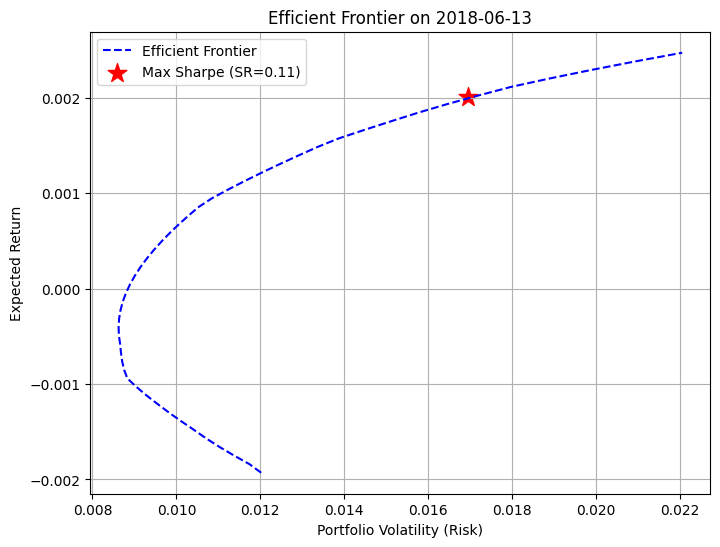

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

day_index = 50
mu_t = P_returns_matrix[day_index, :]
t_idx_real = START_INDEX + day_index
historical_data = R_returns_matrix[t_idx_real - W : t_idx_real, :]
Sigma_t = np.cov(historical_data, rowvar=False)

def portfolio_return(weights, mu):
    return np.dot(weights, mu)

def portfolio_volatility(weights, Sigma):
    return np.sqrt(weights.T @ Sigma @ weights)

num_assets = len(mu_t)
returns_range = np.linspace(min(mu_t), max(mu_t), 50)
frontier_vol = []
frontier_ret = []

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))

for target_return in returns_range:
    constraints_target = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.dot(w, mu_t) - target_return}
    )

    result = minimize(lambda w: w.T @ Sigma_t @ w,
                      np.ones(num_assets)/num_assets,
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints_target)

    if result.success:
        w_opt = result.x
        vol = portfolio_volatility(w_opt, Sigma_t)
        frontier_vol.append(vol)
        frontier_ret.append(target_return)

msr_weights = calculate_msr_weights(mu_t, Sigma_t, RISK_FREE_RATE)
msr_return = portfolio_return(msr_weights, mu_t)
msr_vol = portfolio_volatility(msr_weights, Sigma_t)
sharpe_ratio = (msr_return - RISK_FREE_RATE) / msr_vol

plt.figure(figsize=(8,6))
plt.plot(frontier_vol, frontier_ret, 'b--', label='Efficient Frontier')
plt.scatter(msr_vol, msr_return, color='r', marker='*', s=200, label=f'Max Sharpe (SR={sharpe_ratio:.2f})')
plt.title(f"Efficient Frontier on {day_labels[day_index]}")
plt.xlabel('Portfolio Volatility (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()


The weight matrix is shown in the following table, and the strategy is to allocate funds to each stock based on this weight.

In [ ]:
print(df_weights.head(5).to_string(float_format=lambda x: f'{x * 100:.2f}%'))


             AAPL  MSFT  GOOGL   AMZN  NVDA   META  TSLA
2018-04-03 24.33% 0.00%  0.00% 11.02% 0.00% 62.78% 1.87%
2018-04-04 53.94% 0.00% 23.54%  0.00% 0.00% 22.52% 0.00%
2018-04-05  0.00% 0.00% 60.38%  0.00% 0.00% 39.62% 0.00%
2018-04-06 83.93% 0.00%  0.00%  0.00% 0.00% 16.07% 0.00%
2018-04-09 44.49% 7.09%  0.00% 48.41% 0.00%  0.00% 0.00%


Comparison of the **cumulative return**, **Sharpe ratio**, and **maximum drawdown** of each backtested strategy, including the **MVO-based models** and the **non-MVO LASSO model** (with identical constraints), against an **equal-weight portfolio benchmark**.





--- Starting Final Backtest and Reporting (with Constraints) ---

--- Starting Final Backtest ---
  - Applied 2.0 bps transaction cost.
--- Final Backtest Complete ---
--- Strategy Daily Returns (P&L) List ---
2018-04-03   -0.026136
2018-04-04    0.050451
2018-04-05   -0.023047
2018-04-06   -0.005594
2018-04-09    0.011366
                ...   
2018-12-21   -0.048563
2018-12-24    0.000623
2018-12-26    0.048382
2018-12-27    0.023841
2018-12-28    0.006039
Name: Strategy_Return, Length: 188, dtype: float64

--- Aligning S&P 500 (SPY) Benchmark from existing data ---
S&P 500 benchmark aligned from 2018-04-03 to 2018-12-28.

--- Strategy Performance Analysis (Ridge + MVO) ---
Backtest Period: 2018-04-03 to 2018-12-28
Cumulative Return: 0.14%
Sharpe Ratio: 0.17
Max Drawdown: -37.60%

--- Strategy vs. Benchmarks (Metrics Table) ---
                         Cumulative Return Sharpe Ratio Max Drawdown
Ridge + MVO                          0.14%         0.17      -37.60%
Pure Ridge (Constra

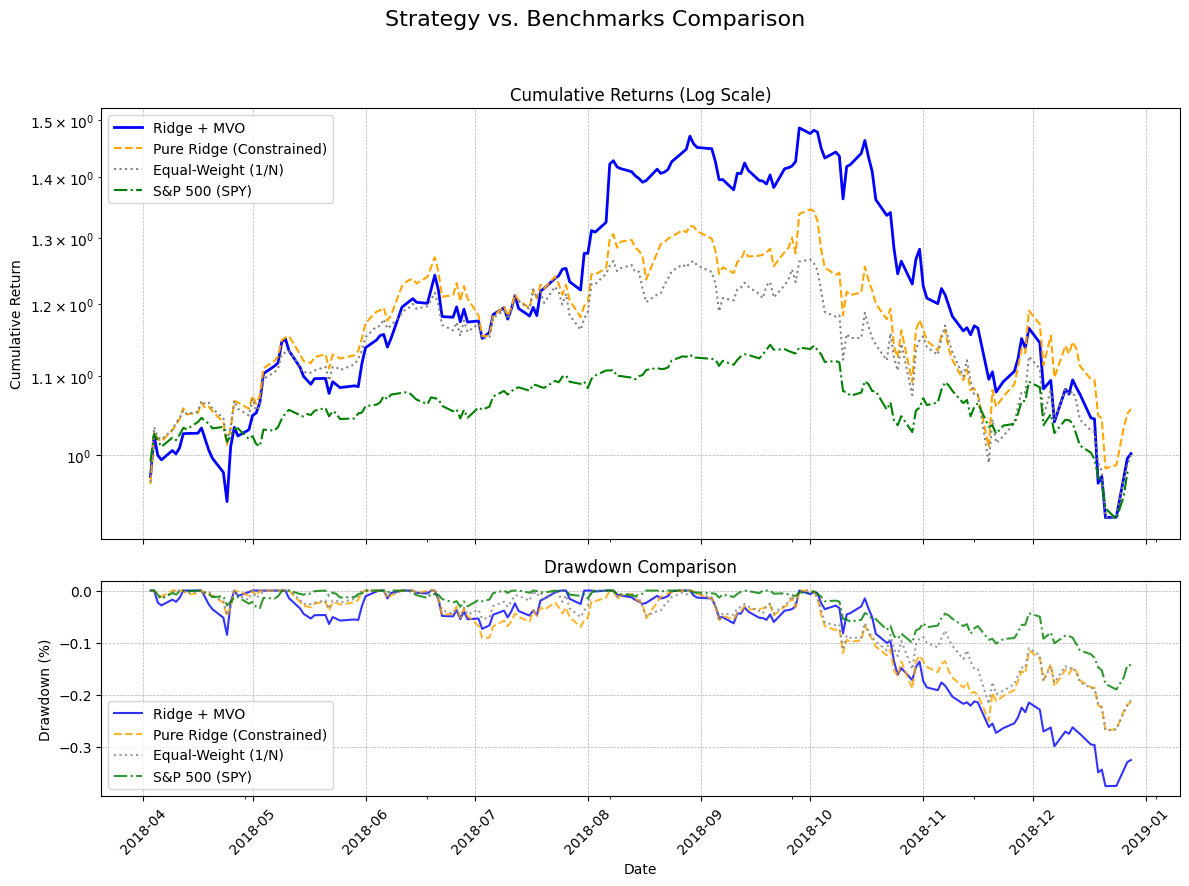

--- Comparison plots displayed ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import minimize


# ============ Utility Functions ============

def run_final_backtest(weights_df, actual_forward_returns_df, transaction_cost_bps=0.0, silent=False):
    """Compute daily portfolio returns (with optional transaction cost)."""
    if not silent:
        print("\n--- Starting Final Backtest ---")
    w_t = weights_df
    r_t_plus_1 = actual_forward_returns_df[w_t.columns]
    daily_returns = (w_t * r_t_plus_1).sum(axis=1)

    if transaction_cost_bps > 0:
        weights_prev = w_t.shift(1).fillna(0)
        turnover = (w_t - weights_prev).abs().sum(axis=1)
        cost_per_day = turnover * (transaction_cost_bps / 10000.0)
        daily_returns = daily_returns - cost_per_day
        if not silent:
            print(f"  - Applied {transaction_cost_bps} bps transaction cost.")

    daily_returns.name = "Strategy_Return"
    if not silent:
        print("--- Final Backtest Complete ---")
    return daily_returns.to_frame()


def calculate_performance_metrics(returns_series, risk_free_rate=0.0):
    """Compute cumulative return, Sharpe ratio, and max drawdown."""
    cumulative_returns = (1 + returns_series).cumprod()
    total_return = cumulative_returns.iloc[-1] - 1
    if returns_series.std() < 1e-6:
        sharpe_ratio = np.nan
    else:
        daily_rf = (1 + risk_free_rate)**(1/252) - 1
        excess_returns = returns_series - daily_rf
        sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)
    roll_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - roll_max) / roll_max
    max_drawdown = drawdown.min()
    metrics_series = pd.Series({
        "Cumulative Return": total_return,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown
    })
    plot_data = {'cumulative_returns': cumulative_returns, 'drawdown': drawdown}
    return plot_data, metrics_series


def generate_comparison_table(metrics_dict):
    """Format metrics for display."""
    comparison_df = pd.DataFrame(metrics_dict)
    formatted_df = comparison_df.T
    formatted_df['Cumulative Return'] = formatted_df['Cumulative Return'].map('{:.2%}'.format)
    formatted_df['Max Drawdown'] = formatted_df['Max Drawdown'].map('{:.2%}'.format)
    formatted_df['Sharpe Ratio'] = formatted_df['Sharpe Ratio'].map('{:.2f}'.format)
    return formatted_df


def calculate_pure_ridge_weights(mu_t, max_weight=0.5):
    """Simplified constrained optimizer used for the 'Pure Ridge' benchmark."""
    num_assets = len(mu_t)
    positive_mu = np.maximum(mu_t, 0)
    sum_pos_mu = positive_mu.sum()
    target_weights = (positive_mu / sum_pos_mu) if sum_pos_mu > 0 else np.ones(num_assets) / num_assets

    def objective(weights):
        # Placeholder objective mimicking a ridge-regularized target-tracking (for demo benchmark)
        return ((weights - target_weights) ** 2).sum()

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, max_weight) for _ in range(num_assets))
    initial_weights = np.ones(num_assets) / num_assets
    res = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return initial_weights if not res.success else res.x


# ============ Main Execution ============

print("\n" + "="*50)
print("--- Starting Final Backtest and Reporting (with Constraints) ---")
print("="*50)

# 1) Prepare input data
Y_actual_matrix = R_returns_matrix[W:]
assert df_weights.shape == Y_actual_matrix.shape, "Shape mismatch between weights and actual returns!"
df_Y_actual = pd.DataFrame(Y_actual_matrix, index=df_weights.index, columns=df_weights.columns)

# 2) Generate constrained Pure-Ridge weights
pure_ridge_weights = np.zeros_like(P_returns_matrix)
for i in range(len(P_returns_matrix)):
    mu_t = P_returns_matrix[i, :]
    pure_ridge_weights[i, :] = calculate_pure_ridge_weights(mu_t, max_weight=0.5)
df_pure_ridge_weights = pd.DataFrame(pure_ridge_weights, index=df_weights.index, columns=df_weights.columns)

# 3) Run backtests for all strategies
strategy_results_df = run_final_backtest(df_weights, df_Y_actual, transaction_cost_bps=2.0, silent=False)
strategy_returns = strategy_results_df['Strategy_Return']

benchmark_returns_eqw = df_Y_actual.mean(axis=1)
pure_ridge_results_df = run_final_backtest(df_pure_ridge_weights, df_Y_actual, transaction_cost_bps=2.0, silent=True)
benchmark_returns_ridge = pure_ridge_results_df['Strategy_Return']

#  Print the Strategy's Daily Returns
print("--- Strategy Daily Returns (P&L) List ---")
print(strategy_returns)

# 4) Add S&P 500 (SPY) benchmark from your existing data
print("\n--- Aligning S&P 500 (SPY) Benchmark from existing data ---")
if ('Open' in data) and ('SPY' in data['Open'].columns):
    spy_open = data['Open']['SPY'].copy()
    spy_open.index = pd.to_datetime(spy_open.index).tz_localize(None)
    spy_open = spy_open.reindex(df_Y_actual.index)
    spy_ret = spy_open.pct_change()
    benchmark_returns_sp500 = spy_ret.shift(-1).reindex(df_Y_actual.index).fillna(0.0)
    benchmark_returns_sp500.name = "S&P 500 (SPY)"
    print(f"S&P 500 benchmark aligned from {benchmark_returns_sp500.index.min()} "
          f"to {benchmark_returns_sp500.index.max()}.")
else:
    raise ValueError("No SPY data found in data['Open']; cannot create S&P 500 benchmark.")

# 5) Compute performance metrics
print("\n--- Strategy Performance Analysis (Ridge + MVO) ---")
plot_data, strat_metrics = calculate_performance_metrics(strategy_returns, risk_free_rate=RISK_FREE_RATE)
print(f"Backtest Period: {strategy_returns.index.min()} to {strategy_returns.index.max()}")
print(f"Cumulative Return: {strat_metrics['Cumulative Return']:.2%}")
print(f"Sharpe Ratio: {strat_metrics['Sharpe Ratio']:.2f}")
print(f"Max Drawdown: {strat_metrics['Max Drawdown']:.2%}")

_, bench_metrics_eqw   = calculate_performance_metrics(benchmark_returns_eqw,   risk_free_rate=RISK_FREE_RATE)
_, bench_metrics_ridge = calculate_performance_metrics(benchmark_returns_ridge, risk_free_rate=RISK_FREE_RATE)
_, bench_metrics_sp500 = calculate_performance_metrics(benchmark_returns_sp500, risk_free_rate=RISK_FREE_RATE)

# 6) Metrics comparison table
print("\n" + "="*50)
print("--- Strategy vs. Benchmarks (Metrics Table) ---")
print("="*50)
all_metrics = {
    "Ridge + MVO": strat_metrics,
    "Pure Ridge (Constrained)": bench_metrics_ridge,
    "Equal-Weight (1/N)": bench_metrics_eqw,
    "S&P 500 (SPY)": bench_metrics_sp500
}
comparison_table = generate_comparison_table(all_metrics)
print(comparison_table)
print("="*50)

# 7) Plot cumulative returns & drawdowns for all four
print("\n--- Generating Strategy Comparison Plot (All 4) ---")

strat_cum_ret = plot_data['cumulative_returns']; strat_drawdown = plot_data['drawdown']
cum_ret_eqw   = (1 + benchmark_returns_eqw).cumprod();   roll_max_eqw   = cum_ret_eqw.cummax();   drawdown_eqw   = (cum_ret_eqw   - roll_max_eqw)   / roll_max_eqw
cum_ret_ridge = (1 + benchmark_returns_ridge).cumprod(); roll_max_ridge = cum_ret_ridge.cummax(); drawdown_ridge = (cum_ret_ridge - roll_max_ridge) / roll_max_ridge
cum_ret_spy   = (1 + benchmark_returns_sp500).cumprod(); roll_max_spy   = cum_ret_spy.cummax();   drawdown_spy   = (cum_ret_spy   - roll_max_spy)   / roll_max_spy

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle("Strategy vs. Benchmarks Comparison", fontsize=16)

# --- Plot 1: cumulative returns ---
strat_cum_ret.plot(ax=ax1, label="Ridge + MVO", color='blue', linewidth=2.0)
cum_ret_ridge.plot(ax=ax1, label="Pure Ridge (Constrained)", color='orange', linestyle='--')
cum_ret_eqw.plot(ax=ax1,   label="Equal-Weight (1/N)",      color='grey',   linestyle=':')
cum_ret_spy.plot(ax=ax1,   label="S&P 500 (SPY)",           color='green',  linestyle='-.')

ax1.set_title("Cumulative Returns (Log Scale)")
ax1.set_ylabel("Cumulative Return")
ax1.set_yscale('log')
ax1.grid(True, linestyle='--', linewidth=0.5)
ax1.legend(loc='upper left')

# --- Plot 2: drawdowns ---
strat_drawdown.plot(ax=ax2, label="Ridge + MVO", color='blue', alpha=0.8)
drawdown_ridge.plot(ax=ax2, label="Pure Ridge (Constrained)", color='orange', linestyle='--', alpha=0.8)
drawdown_eqw.plot(ax=ax2,   label="Equal-Weight (1/N)", color='grey', linestyle=':', alpha=0.8)
drawdown_spy.plot(ax=ax2,   label="S&P 500 (SPY)", color='green', linestyle='-.', alpha=0.8)

ax2.set_title("Drawdown Comparison")
ax2.set_ylabel("Drawdown (%)")
ax2.set_xlabel("Date")
ax2.grid(True, linestyle='--', linewidth=0.5)
ax2.legend(loc='lower left')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("--- Comparison plots displayed ---")
